<a href="https://colab.research.google.com/github/Dowlatabadi/Dowlatabadi/blob/main/agg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import HTML, display
from IPython.display import clear_output

from gomoku.Board import Board,GameResult,CROSS,NAUGHT
from gomoku.MinMaxPlayerL import MinMaxPlayerL
from gomoku.RandomPlayer import RandomPlayer
from gomoku.CNExpDoubleDuelQPlayer import CNExpDoubleDuelQPlayer
#from gomoku.Utility import play_game,complete_run,print_board,run_and_chart
from gomoku.Player import Player,REWARD_METHOD
from gomoku.TFSessionManager import TFSessionManager
import tensorflow.compat.v1 as tf
import numpy as np
import time
import matplotlib.pyplot as plt


In [ ]:

hours=1

def play_game(board: Board, player1: Player, player2: Player,verbose=False,reverse_results=False):

    print("---------------------------------------")

    player1.new_game(CROSS)
    player2.new_game(NAUGHT)
    p1_time=0
    p2_time=0
    threads=0
    #board.reset()
    board=Board(verbose=verbose)
    #last_state=[]
    moves_num=0
    previous_board=None
    finished = False
    while not finished:
        #print_board(board)
        #last_state=board.state.copy()
        start_time = time.time()
        result, finished = player1.move(board)
        end_time = time.time()
        elapsed_time = end_time - start_time
        p1_time+=elapsed_time
        moves_num+=1
        if finished:
            if result == GameResult.DRAW:
                final_result = GameResult.DRAW
            else:
                final_result = GameResult.CROSS_WIN
        else:
            #last_state=board.state.copy()
            start_time = time.time()
            previous_board=Board(s=board.state)
            start_time = time.time()
            result, finished = player2.move(board)
            end_time = time.time()
            elapsed_time = end_time - start_time
            p2_time+=elapsed_time
            moves_num+=1
            if finished:
                if result == GameResult.DRAW:
                    final_result = GameResult.DRAW
                else:
                    final_result = GameResult.NAUGHT_WIN
            # noinspection PyUnboundLocalVariable
    player1.final_result(final_result)
    player2.final_result(final_result)
    th=0
    reward=0
    if reverse_results:
        threads+=player2.get_threads()
        th=player2.get_threads()
        #print("p2 rew",player2.get_reward())
        reward=player2.get_reward()
    else:
        threads+=player1.get_threads()
        th=player1.get_threads()
        reward=player1.get_reward()
    # noinspection PyUnboundLocalVariable
    #threads+=player2.get_threads()
    #print(final_result)
    #if (final_result==GameResult.CROSS_WIN):
    #    print_board(board)
    #    print_board(previous_board)
    print("p and p2 time ",round(p1_time,2),round(p2_time,2),
          "length",moves_num,"threats",threads,
          f"{player1.get_art_name()} vs {player2.get_art_name()} threats",th,"reward",reward,0)
    #reward=min(reward,2000)
    return final_result,moves_num,th,reward

In [ ]:

def battle(p1:Player,p2:Player,match_num,reverse_results=False):
    res=[]
    b1=Board()
    for i in range(match_num):

        #print(i)
        res.append(play_game(b1,p1,p2,reverse_results=reverse_results))
    return res



def complete_run(p1:Player,p2:Player,battle_num : int,match_num : int,session_on=True,session_off=True
                 ,clear_trained=True,max_minutes=6*60/12,reverse_results=False):
    if session_on:
        TFSessionManager.set_session(tf.Session())
    if clear_trained:
        TFSessionManager.get_session().run(tf.global_variables_initializer())

    print("complete battle between",p1.get_name(),p2.get_name())
    game_results=[GameResult.NOT_FINISHED ,
    GameResult.CROSS_WIN ,
    GameResult.NAUGHT_WIN,
    GameResult.DRAW ]
    res=[]
    complete_start_time = time.time()

    for i in range(battle_num):


        percent=round((100*(i+1))/battle_num,1)
        elapsed_time =1+( time.time() - complete_start_time)
        #sleep ever 30 minutes
        if 29>elapsed_time%30>24:
            print("sleeping....")
            #time.sleep(1*20)
        speed=((percent+.01)/(elapsed_time))
        if (elapsed_time//60)>max_minutes:
            print("time out",elapsed_time//60,"number of matches",(i+1)*match_num)
            break
        print("speed",speed)
        remaining=(100-percent)/speed
        hours=round(remaining // 3600)
        minutes=round((remaining % 3600)//60)
        print("battle num",i,"percent %",percent,"remaining time",hours,":",minutes,", 0 :",max_minutes-(elapsed_time//60))

        battle_result=battle(p1,p2,match_num,reverse_results=reverse_results)
        #print(battle_result)
        battle_npresult=np.array(battle_result, dtype=object)
        #plt.hist(data, bins=70, density=True)
        # Add labels and title
        #plt.xlabel('Value')
        #plt.ylabel('Frequency')
        #plt.title('Distribution of Values')
        gametype_infos=[]
        mean_moves = np.mean(battle_npresult[:, 1])
        gametype_infos.append(mean_moves)
        mean_threads = np.mean(battle_npresult[:, 2])
        gametype_infos.append(mean_threads)
        mean_reward = np.mean(battle_npresult[:, 3])
        gametype_infos.append(mean_reward)
        # Print the result

        for r in game_results:
            mask=battle_npresult[:, 0]==r
            perc=mask.mean() * 100
            num=mask.sum()
            #gametype_infos.append(r)
            gametype_infos.append(perc)
        res.append(gametype_infos)

        # Show the plot
        #plt.show()
    if session_off:
        TFSessionManager.set_session(None)
    end_time = time.time()
    elapsed_time = end_time - complete_start_time
    print(f"Elapsed time: {elapsed_time} seconds")
    return np.array(res, dtype=object)
def draw_chart(run_res,p1,p2,number_of_games=1,win_for_p=1):
    game_length=run_res[:, 0]
    game_threads=run_res[:, 1]
    game_reward=np.clip(run_res[:, 2], 0,100000)
    print(game_threads)
    p1_wins=run_res[:, 4]
    p2_wins=run_res[:, 5]
    draws=run_res[:, 6]


    #print(battle_npresult)
    plt.clf()
    plt.title('Scatter Plot of X,Y Data')
    plt.ylabel('Game outcomes in %')
    plt.xlabel('Game number')
    count=[x*number_of_games for x in range(len(game_threads))]
    plt.plot(count, game_threads, 'm--' ,marker='o', label='Threads')
    plt.plot(count, draws, 'r:',  marker='s',label='Draw')
    plt.plot(count, p1_wins, 'g-', marker='^', label=p1.get_name())
    plt.plot(count, p2_wins, 'b-', marker='*', label=p2.get_name())
    plt.plot(count, game_length, 'y--', marker='o', label='length')
    plt.legend(loc='best', shadow=True, fancybox=True, framealpha =0.7)
    # Show the plot
    plt.xticks(rotation=90)
    plt.show()
    print("overall results",
          "threads",np.mean(game_threads),
          "draws",np.mean(draws),
          f"win p1 >> {p1.get_name()}",np.mean(p1_wins),
           f"win p2 >> {p2.get_name()}",np.mean(p2_wins),
          "length",np.mean(game_length),
         "reward",np.mean(game_reward)
         )

    plt.clf()
    fig, ax = plt.subplots()
    ax.semilogy(count, game_reward, 'k--', marker='o', label='reward')

    # Add labels and title
    ax.set_xlabel('Game number')
    ax.set_ylabel('Game Reward')
    ax.set_title('Scatter Plot of X,Y Data')


    plt.legend(loc='best', shadow=True, fancybox=True, framealpha =0.7)
    # Show the plot
    plt.xticks(rotation=90)
    plt.show()

    if win_for_p==1:
        return np.mean(game_threads),np.mean(game_length),np.mean(p1_wins),np.mean(draws)
    else:
        return np.mean(game_threads),np.mean(game_length),np.mean(p2_wins),np.mean(draws)


agents=['Aggressive e-agent','Defensive e-agent','Winning agent(DDQN)']
Threats_dict={
    agents[0]:[],
    agents[1]:[],
    agents[2]:[]
}
Lengths_dict={
    agents[0]:[],
    agents[1]:[],
    agents[2]:[]

}
Wins_dict={
    agents[0]:[]
    ,agents[1]:[]
    ,agents[2]:[]

}
Draws_dict={
    agents[0]:[]
    ,agents[1]:[]
    ,agents[2]:[]

}
mult_dict={
    agents[0]:[]
    ,agents[1]:[]
    ,agents[2]:[]

}

def draw_finalchart(agents,data_dict,chart_name,y_name=''):
    settings={
        1:['#d62728','o','--'],
        2:['#2ca02c','^','--'],
       3:['#1f77b4','*','-'],
        4:['y','*','--'],

    }
    i=0
    #print(battle_npresult)
    plt.clf()
    plt.title(chart_name)
    plt.ylabel(y_name)
    plt.xlabel('Oponent(Winning Agent) type')
    #print(data_dict)
    for a,p in data_dict.items():
        i+=1
        #p.sort(key=lambda x: x[0])
        x = [t[0] for t in p]
        y = [t[1] for t in p]
        print("level",a)
        plt.plot(x,y, settings[i][0] ,linestyle = settings[i][2],marker= settings[i][1], label=a)
        #plt.xlim(x[0]-2.0, x[-1]+2.0)
    plt.legend(loc='best', shadow=True, fancybox=True, framealpha =0.6)
    plt.show()

def append_to_overall(p,overall_results,agent_id=0):

    #order list
    order_list=['Random','DDNQ (hard)','Det minimax','N-det minimax']

    agent_name=agents[agent_id]
    art_name=p.get_art_name()
    #print('bef',Threats_dict)
    Threats_dict[agent_name]=sorted([(x,y) for (x,y) in Threats_dict[agent_name] if x!=art_name]+[(art_name,overall_results[0])], key=lambda x: order_list.index(x[0]))
    Lengths_dict[agent_name]=sorted([(x,y) for (x,y) in Lengths_dict[agent_name] if x!=art_name]+[(art_name,overall_results[1])], key=lambda x: order_list.index(x[0]))
    Wins_dict[agent_name]=sorted([(x,y) for (x,y) in Wins_dict[agent_name] if x!=art_name]+[(art_name,overall_results[2])], key=lambda x: order_list.index(x[0]))
    Draws_dict[agent_name]=sorted([(x,y) for (x,y) in Draws_dict[agent_name] if x!=art_name]+[(art_name,overall_results[3])], key=lambda x: order_list.index(x[0]))
    #mult_dict[agent_name]=[(x,y) for (x,y) in Threats_dict[agent_name] if x!=art_name]+[(1+overall_results[0])*overall_results[1]]
    #print('aft',Threats_dict)


In [ ]:
tf.reset_default_graph()
tf.compat.v1.disable_eager_execution()
DDNQ_Rew_defensive=CNExpDoubleDuelQPlayer("DDNQ_Rew_defensive",length_reward=True,thread_reward=True,aggression=False,verbose=False,length_multiplier=1/10,reward_method=REWARD_METHOD.POLY)
DDNQ_Rew_defensive2=CNExpDoubleDuelQPlayer("DDNQ_Rew_defensive2",length_reward=True,thread_reward=True,aggression=False,verbose=False,length_multiplier=1/10,reward_method=REWARD_METHOD.POLY)
DDNQ_Rew_aggressive=CNExpDoubleDuelQPlayer("DDNQ_Rew_aggressive",length_reward=True,thread_reward=True,aggression=True,verbose=False,length_multiplier=1/10,reward_method=REWARD_METHOD.POLY)
DDQN=CNExpDoubleDuelQPlayer("DDQN",length_reward=False,medium_diff=False)
DDNQ_med=CNExpDoubleDuelQPlayer("DDNQ_med",length_reward=False,medium_diff=True)
DDNQ_hard=CNExpDoubleDuelQPlayer("DDNQ_hard",length_reward=False)
minmaxplayer=MinMaxPlayerL(depth=2,branch=45,read_file=False,rnd=False)
minmaxplayerrnd=MinMaxPlayerL(depth=2,branch=45,read_file=False,rnd=True)
rndplayer=RandomPlayer(obvious_wisdom=True)

max_minutes=5

In [ ]:
#warm up phase
warmup=True
co=10
if warmup:
    number_of_games=1
    number_of_battles=100*co

    #run_res=complete_run(DDNQ_Rew_aggressive,DDNQ_med,3*number_of_battles,number_of_games,session_on=True,session_off=False,clear_trained=True,max_minutes=10)
    run_res=complete_run(DDNQ_Rew_aggressive,DDNQ_hard,3*number_of_battles,number_of_games,session_on=True,session_off=False,clear_trained=True,max_minutes=max_minutes)

    run_res=complete_run(DDNQ_Rew_aggressive,rndplayer,number_of_battles,number_of_games,session_on=False,session_off=False,clear_trained=False,max_minutes=max_minutes)

    run_res=complete_run(DDNQ_Rew_aggressive,minmaxplayer,2*number_of_battles,number_of_games,session_on=False,session_off=False,clear_trained=False,max_minutes=max_minutes)

    run_res=complete_run(DDNQ_Rew_aggressive,minmaxplayerrnd,2*number_of_battles,number_of_games,session_on=False,session_off=False,clear_trained=False,max_minutes=max_minutes)

    #defensive

    #run_res=complete_run(DDNQ_Rew_defensive,DDNQ_med,3*number_of_battles,number_of_games,session_on=False,session_off=False,clear_trained=False,max_minutes=10)
    run_res=complete_run(DDNQ_hard,DDNQ_Rew_defensive,3*number_of_battles,number_of_games,session_on=False,session_off=False,clear_trained=False,max_minutes=max_minutes,reverse_results=True)
    run_res=complete_run(DDNQ_Rew_defensive2,DDNQ_Rew_defensive,2*number_of_battles,number_of_games,session_on=False,session_off=False,clear_trained=False,max_minutes=max_minutes,reverse_results=True)
    run_res=complete_run(rndplayer,DDNQ_Rew_defensive,number_of_battles,number_of_games,session_on=False,session_off=False,clear_trained=False,max_minutes=max_minutes,reverse_results=True)

    run_res=complete_run(minmaxplayer,DDNQ_Rew_defensive,2*number_of_battles,number_of_games,session_on=False,session_off=False,clear_trained=False,max_minutes=max_minutes,reverse_results=True)

    run_res=complete_run(minmaxplayerrnd,DDNQ_Rew_defensive,2*number_of_battles,number_of_games,session_on=False,session_off=False,clear_trained=False,max_minutes=max_minutes,reverse_results=True)


    #DDQN


   # run_res=complete_run(DDNQ_Rew_defensive,DDQN,number_of_battles,number_of_games,session_on=False,session_off=False,clear_trained=False)
   # run_res=complete_run(DDNQ_Rew_aggressive,DDQN,number_of_battles,number_of_games,session_on=False,session_off=False,clear_trained=False)

    #run_res=complete_run(DDQN,rndplayer,number_of_battles,number_of_games,session_on=False,session_off=False,clear_trained=False)

    run_res=complete_run(DDQN,minmaxplayer,number_of_battles,number_of_games,session_on=False,session_off=False,clear_trained=False,max_minutes=max_minutes)

    run_res=complete_run(DDQN,minmaxplayerrnd,number_of_battles,number_of_games,session_on=False,session_off=False,clear_trained=False,max_minutes=max_minutes)




complete battle between ExpDuelQ engaging, reward mthd:REWARD_METHOD.POLY aggressive ExpDuelQ competitor for win(hard)
speed 0.009999794964226026
battle num 0 percent % 0.0 remaining time 2 : 46 , 0 : 5.0
---------------------------------------
threat,1,6
PreTrained by picking random moves 0<200
lnth exp reward Duel 19.6
ExpDuelQ engaging, reward mthd:REWARD_METHOD.POLY aggressive assumes win 15.68 disc 15.0528
PreTrained by picking random moves 0<200
ExpDuelQ competitor for win(hard) assumes loss -1.0 disc 0.0
p and p2 time  0.15 0.13 length 27 threats 1 DDNQ E-aggressive vs DDNQ (hard) threats 1 reward 15.68 0
speed 0.08513171172750379
battle num 1 percent % 0.1 remaining time 0 : 19 , 0 : 5.0
---------------------------------------
threat,7,1
PreTrained by picking random moves 1<200
lnth exp reward Duel 48.400000000000006
ExpDuelQ engaging, reward mthd:REWARD_METHOD.POLY aggressive assumes win 38.72 disc 15.0528
PreTrained by picking random moves 1<200
ExpDuelQ competitor for win(ha

KeyboardInterrupt: ignored

complete battle between ExpDuelQ engaging, reward mthd:REWARD_METHOD.POLY aggressive rnd plyr
speed 0.0099999332432435
battle num 0 percent % 0.0 remaining time 2 : 46 , 0 : 120.0
---------------------------------------
threat,5,3
ExpDuelQ engaging, reward mthd:REWARD_METHOD.POLY aggressive assumes loss 0.0 disc 15.0528
batch size 10000 buffers win loss draw 1587 1948 0
p and p2 time  0.07 0.03 length 17 threats 1 DDNQ E-aggressive vs Random threats 1 reward 0.0 0
---------------------------------------
threat,5,5
lnth exp reward Duel 14.4
ExpDuelQ engaging, reward mthd:REWARD_METHOD.POLY aggressive assumes loss 11.52 disc 15.0528
batch size 10000 buffers win loss draw 1587 1959 0
p and p2 time  0.14 0.06 length 23 threats 1 DDNQ E-aggressive vs Random threats 1 reward 11.52 0
---------------------------------------
threat,4,6
ExpDuelQ engaging, reward mthd:REWARD_METHOD.POLY aggressive assumes loss 0.0 disc 15.0528
batch size 10000 buffers win loss draw 1587 1967 0
p and p2 time  0.06

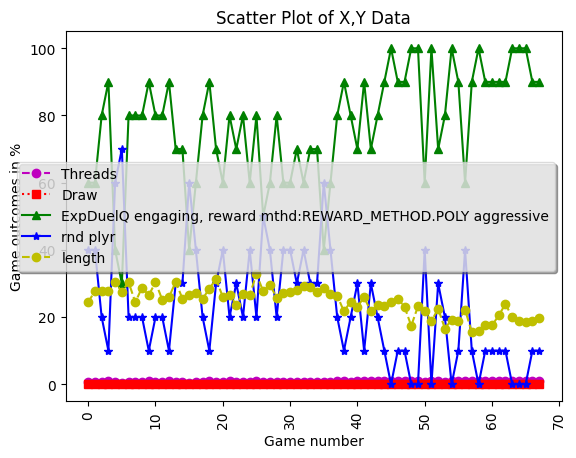

overall results threads 0.8279411764705881 draws 0.0 win p1 >> ExpDuelQ engaging, reward mthd:REWARD_METHOD.POLY aggressive 77.20588235294117 win p2 >> rnd plyr 22.794117647058822 length 24.589705882352945 reward 11.905058823529416


<Figure size 640x480 with 0 Axes>

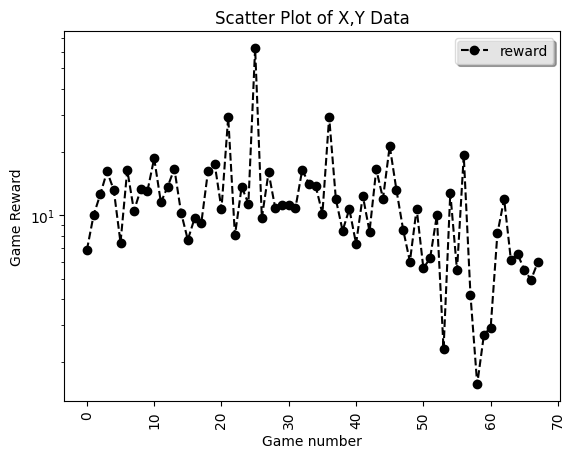

In [ ]:
#agg
#rand
number_of_games=10
number_of_battles=1000*co

run_res=complete_run(DDNQ_Rew_aggressive,rndplayer,number_of_battles
                     ,number_of_games,session_on=False,session_off=False,clear_trained=False,max_minutes=120)
overall_results=draw_chart(run_res,DDNQ_Rew_aggressive,rndplayer)

append_to_overall(rndplayer,overall_results)

In [ ]:
#agg
#hard
co=100
number_of_games=30
number_of_battles=100*co

run_res=complete_run(DDNQ_Rew_aggressive,DDNQ_hard,number_of_battles,number_of_games,session_on=False
                     ,session_off=False,clear_trained=False,max_minutes=100)
overall_results=draw_chart(run_res,DDNQ_Rew_aggressive,DDNQ_hard,number_of_games=number_of_games)

append_to_overall(DDNQ_hard,overall_results)

complete battle between ExpDuelQ engaging, reward mthd:REWARD_METHOD.POLY aggressive ExpDuelQ competitor for win(hard)
speed 0.009999914170048209
battle num 0 percent % 0.0 remaining time 2 : 46 , 0 : 45.0
---------------------------------------
threat,5,4
lnth exp reward Duel 12.100000000000001
ExpDuelQ engaging, reward mthd:REWARD_METHOD.POLY aggressive assumes loss 9.68 disc 15.0528
batch size 10000 buffers win loss draw 5005 6475 0
ExpDuelQ competitor for win(hard) assumes loss -1.0 disc 0.0
batch size 10000 buffers win loss draw 1383 1735 0
p and p2 time  0.08 0.07 length 21 threats 1 DDNQ E-aggressive vs DDNQ (hard) threats 1 reward 9.68 0
---------------------------------------
threat,7,4
ExpDuelQ engaging, reward mthd:REWARD_METHOD.POLY aggressive assumes loss 0.0 disc 15.0528
batch size 10000 buffers win loss draw 5005 6481 0
ExpDuelQ competitor for win(hard) assumes loss -1.0 disc 0.0
batch size 10000 buffers win loss draw 1383 1740 0
p and p2 time  0.05 0.04 length 13 threat

# New Section

In [ ]:
#agg
#det min max
number_of_games=40
number_of_battles=200*co
run_res=complete_run(DDNQ_Rew_aggressive,minmaxplayer,number_of_battles,number_of_games,session_on=False
                     ,session_off=False,clear_trained=False,max_minutes=120)
overall_results=draw_chart(run_res,DDNQ_Rew_aggressive,minmaxplayer,number_of_games=number_of_games)


append_to_overall(minmaxplayer,overall_results)

In [ ]:
#agg
# non det minimax
number_of_games=40
number_of_battles=200*co
run_res=complete_run(DDNQ_Rew_aggressive,minmaxplayerrnd,number_of_battles,number_of_games,session_on=False
                     ,session_off=False,clear_trained=False,max_minutes=120)
overall_results=draw_chart(run_res,DDNQ_Rew_aggressive,minmaxplayerrnd,number_of_games=number_of_games)

append_to_overall(minmaxplayerrnd,overall_results)